In [1]:
import pandas as pd
import numpy as np

from os.path import exists
from os import mkdir

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import open3d as o3d
from utils import *

#%env OPEN3D_CPU_RENDERING true

mpl.rcParams["figure.dpi"] = 300
mpl.rcParams["legend.fontsize"] = 12
mpl.rcParams["font.size"] = 12

PLOTDIR = "plots"
DATADIR = "data"

DIRS = [PLOTDIR, DATADIR]

def plot_savepath(filename):
    return PLOTDIR + f"/{filename}"

def data_path(filename):
    return DATADIR + f"/{filename}"

for d in DIRS:
    if not exists(d):
        mkdir(d)
              
output_dir = f"figures/experiments/"

In [2]:
Organoid_Names = ['697_1_MAP2.xls',
                  '697_2_MAP2.xls', 
                  '697_3_MAP2.xls',
                  '697_4_MAP2.xls',
                  'BCELL_1_MAP2.xls',
                  'BCELL_2_MAP2.xls', 
                  'BCELL_3_MAP2.xls',
                  'BCELL_4_MAP2.xls']

organoid_pts = []

for name in Organoid_Names:
    df = pd.read_excel(data_path(name), header = None, skiprows =1)
    df = df.rename(columns = df.iloc[0]).drop(df.index[0])
    df_drop = df.drop(columns=['Unit', 'Category', 'Collection', 'Time', 'ID'])
    pts = df_drop.to_numpy()
    organoid_pts.append(pts)

In [3]:
Entity_Names = ['697_1_CFSE.xls',
                '697_2_CFSE.xls', 
                '697_3_CFSE.xls',
                '697_4_CFSE.xls',
                'BCELL_1_CFSE.xls',
                'BCELL_2_CFSE.xls', 
                'BCELL_3_CFSE.xls',
                'BCELL_4_CFSE.xls']

entity_pts = []

for name in Entity_Names:
    df = pd.read_excel(data_path(name), header = None, skiprows =1)
    df = df.rename(columns = df.iloc[0]).drop(df.index[0])
    df_drop = df.drop(columns=['Unit', 'Category', 'Collection', 'Time', 'ID'])
    pts = df_drop.to_numpy()
    entity_pts.append(pts)

In [4]:
assert len(organoid_pts)==len(entity_pts)

distances = []

for index in range(len(organoid_pts)):
    # Organoids
    pcd_org = o3d.geometry.PointCloud()
    pcd_org.points = o3d.utility.Vector3dVector(organoid_pts[index])
    pcd_org.compute_convex_hull()
    pcd_org.estimate_normals()
    pcd_org.orient_normals_consistent_tangent_plane(10)
    
    with o3d.utility.VerbosityContextManager(
            o3d.utility.VerbosityLevel.Debug) as cm:
        mesh_org, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(
            pcd_org, depth=10, scale=10, linear_fit=True)
    # print(mesh)
    mesh_org.paint_uniform_color([0.8, 0.2, 0])
    mesh_org.compute_vertex_normals()
    mesh_org.filter_smooth_simple(number_of_iterations=5)
    
    mesh_to_fill_org = o3d.t.geometry.TriangleMesh.from_legacy(mesh_org)
    mesh_to_fill_org.fill_holes(hole_size=10)
    final_mesh_org = mesh_to_fill_org.to_legacy()
    
    # Entities
    pcd_ent = o3d.geometry.PointCloud()
    pcd_ent.points = o3d.utility.Vector3dVector(entity_pts[index])
    pcd_ent.compute_convex_hull()
    pcd_ent.estimate_normals()
    pcd_ent.orient_normals_consistent_tangent_plane(10)
    
    with o3d.utility.VerbosityContextManager(
            o3d.utility.VerbosityLevel.Debug) as cm:
        mesh_ent, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(
            pcd_ent, depth=10, scale=10, linear_fit=True)
    # print(mesh)
    mesh_ent.paint_uniform_color([0.8, 0.2, 0])
    mesh_ent.compute_vertex_normals()
    mesh_ent.filter_smooth_simple(number_of_iterations=5)
    
    mesh_to_fill_ent = o3d.t.geometry.TriangleMesh.from_legacy(mesh_ent)
    mesh_to_fill_ent.fill_holes(hole_size=10)
    final_mesh_ent = mesh_to_fill_ent.to_legacy()
    
    # Calculation of distances
    mesh_org_toleg = o3d.t.geometry.TriangleMesh.from_legacy(final_mesh_org)
    mesh_ent_toleg = o3d.t.geometry.TriangleMesh.from_legacy(final_mesh_ent)
    
    scene = o3d.t.geometry.RaycastingScene()
    mesh_ids = {}
    mesh_ids[scene.add_triangles(mesh_org_toleg)] = 'surface'
    mesh_ids[scene.add_triangles(mesh_ent_toleg)] = 'cells'

    query_point = np.asarray(entity_pts[index]).astype('float32')

    unsigned_distance = scene.compute_distance(query_point)
    distances.append(unsigned_distance.numpy())

[Open3D DEBUG] Input Points / Samples: 27203 / 24034
[Open3D DEBUG] #   Got kernel density: 0.00576901 (s), 338.0 (MB) / 338.0 (MB) / 338 (MB)
[Open3D DEBUG] #     Got normal field: 0.0702229 (s), 344.16 (MB) / 344.16 (MB) / 344 (MB)
[Open3D DEBUG] Point weight / Estimated Area: 1.600072e-06 / 4.352675e-02
[Open3D DEBUG] #       Finalized tree: 0.0476031 (s), 356.312 (MB) / 356.312 (MB) / 356 (MB)
[Open3D DEBUG] #  Set FEM constraints: 0.0648029 (s), 358.164 (MB) / 358.164 (MB) / 358 (MB)
[Open3D DEBUG] #Set point constraints: 0.00803590 (s), 359.488 (MB) / 359.488 (MB) / 359 (MB)
[Open3D DEBUG] Leaf Nodes / Active Nodes / Ghost Nodes: 288149 / 325416 / 3897
[Open3D DEBUG] Memory Usage: 359.488 MB
[Open3D DEBUG] # Linear system solved: 0.175851 (s), 367.34 (MB) / 367.34 (MB) / 367 (MB)
[Open3D DEBUG] Got average: 0.00657892 (s), 367.434 (MB) / 367.434 (MB) / 367 (MB)
[Open3D DEBUG] Iso-Value: 5.085181e-01 = 1.383322e+04 / 2.720300e+04
Cycle[0] Depth[ 0/10]:	Updated constraints / Got sy

[WARNING] /Users/runner/work/Open3D/Open3D/build/poisson/src/ext_poisson/PoissonRecon/Src/FEMTree.IsoSurface.specialized.inl (Line 1858)
          Extract
          bad average roots: 3


[Open3D DEBUG] #          Total Solve:       1.0 (s),     421.8 (MB)
[Open3D WARNING] Ignoring attribute 'normals' for TensorMap with primary key 'indices'
Cycle[0] Depth[ 0/10]:	Updated constraints / Got system / Solved in:  0.000 /  0.000 /  0.000	(415.215 MB)	Nodes: 8
CG: 8.8841e-03 -> 8.8841e-03 -> 5.5619e-06 (6.3e-04) [32675]
Cycle[0] Depth[ 1/10]:	Updated constraints / Got system / Solved in:  0.001 /  0.000 /  0.000	(415.215 MB)	Nodes: 27
  GS: 6.0944e-02 -> 6.0944e-02 -> 7.8165e-04 (1.3e-02) [8]
Cycle[0] Depth[ 2/10]:	Updated constraints / Got system / Solved in:  0.001 /  0.000 /  0.000	(415.215 MB)	Nodes: 125
    GS: 9.2572e-02 -> 9.2572e-02 -> 1.9124e-03 (2.1e-02) [8]
Cycle[0] Depth[ 3/10]:	Updated constraints / Got system / Solved in:  0.001 /  0.001 /  0.000	(415.215 MB)	Nodes: 729
      GS: 1.5478e-01 -> 1.5478e-01 -> 3.0526e-03 (2.0e-02) [8]
Cycle[0] Depth[ 4/10]:	Updated constraints / Got system / Solved in:  0.001 /  0.003 /  0.002	(415.301 MB)	Nodes: 4913
        GS: 

[Open3D DEBUG] Input Points / Samples: 1219 / 1076
[Open3D DEBUG] #   Got kernel density: 0.00127506 (s), 584.75 (MB) / 584.75 (MB) / 584 (MB)
[Open3D DEBUG] #     Got normal field: 0.00329399 (s), 584.75 (MB) / 584.75 (MB) / 584 (MB)
[Open3D DEBUG] Point weight / Estimated Area: 2.174073e-05 / 2.650195e-02
[Open3D DEBUG] #       Finalized tree: 0.0147929 (s), 584.75 (MB) / 584.75 (MB) / 584 (MB)
[Open3D DEBUG] #  Set FEM constraints: 0.0307250 (s), 584.75 (MB) / 584.75 (MB) / 584 (MB)
[Open3D DEBUG] #Set point constraints: 0.00128984 (s), 584.75 (MB) / 584.75 (MB) / 584 (MB)
[Open3D DEBUG] Leaf Nodes / Active Nodes / Ghost Nodes: 87067 / 88872 / 10633
[Open3D DEBUG] Memory Usage: 584.750 MB
[Open3D DEBUG] # Linear system solved: 0.076236 (s), 584.809 (MB) / 584.809 (MB) / 584 (MB)
[Open3D DEBUG] Got average: 0.00465703 (s), 584.809 (MB) / 584.809 (MB) / 584 (MB)
[Open3D DEBUG] Iso-Value: 5.251072e-01 = 6.401057e+02 / 1.219000e+03
[Open3D DEBUG] #          Total Solve:       1.0 (s),  

B)	Nodes: 1696
                    GS: 2.6742e-02 -> 2.6742e-02 -> 3.6564e-04 (1.4e-02) [8]
Cycle[0] Depth[ 0/10]:	Updated constraints / Got system / Solved in:  0.000 /  0.000 /  0.000	(644.211 MB)	Nodes: 8
CG: 1.1730e-02 -> 1.1730e-02 -> 8.7599e-07 (7.5e-05) [32675]
Cycle[0] Depth[ 1/10]:	Updated constraints / Got system / Solved in:  0.001 /  0.000 /  0.000	(644.211 MB)	Nodes: 27
  GS: 5.8906e-02 -> 5.8906e-02 -> 9.8578e-04 (1.7e-02) [8]
Cycle[0] Depth[ 2/10]:	Updated constraints / Got system / Solved in:  0.001 /  0.000 /  0.000	(644.211 MB)	Nodes: 125
    GS: 8.9459e-02 -> 8.9459e-02 -> 2.3806e-03 (2.7e-02) [8]
Cycle[0] Depth[ 3/10]:	Updated constraints / Got system / Solved in:  0.001 /  0.002 /  0.000	(644.211 MB)	Nodes: 729
      GS: 1.5084e-01 -> 1.5084e-01 -> 3.7470e-03 (2.5e-02) [8]
Cycle[0] Depth[ 4/10]:	Updated constraints / Got system / Solved in:  0.001 /  0.003 /  0.001	(644.211 MB)	Nodes: 4913
        GS: 2.0131e-01 -> 2.0131e-01 -> 3.8268e-03 (1.9e-02) [8]
Cycle[0] De

[Open3D DEBUG] #          Total Solve:       1.3 (s),     693.1 (MB)
[Open3D WARNING] Ignoring attribute 'normals' for TensorMap with primary key 'indices'
[Open3D DEBUG] Input Points / Samples: 928 / 774
[Open3D DEBUG] #   Got kernel density: 0.000865936 (s), 693.285 (MB) / 693.285 (MB) / 693 (MB)
[Open3D DEBUG] #     Got normal field: 0.00255680 (s), 693.285 (MB) / 693.285 (MB) / 693 (MB)
[Open3D DEBUG] Point weight / Estimated Area: 2.079652e-05 / 1.929917e-02
[Open3D DEBUG] #       Finalized tree: 0.013942 (s), 693.285 (MB) / 693.285 (MB) / 693 (MB)
[Open3D DEBUG] #  Set FEM constraints: 0.0295219 (s), 693.301 (MB) / 693.301 (MB) / 693 (MB)
[Open3D DEBUG] #Set point constraints: 0.00115681 (s), 693.301 (MB) / 693.301 (MB) / 693 (MB)
[Open3D DEBUG] Leaf Nodes / Active Nodes / Ghost Nodes: 79556 / 84792 / 6129
[Open3D DEBUG] Memory Usage: 693.301 MB
[Open3D DEBUG] # Linear system solved: 0.0768778 (s), 693.301 (MB) / 693.301 (MB) / 693 (MB)
[Open3D DEBUG] Got average: 0.00463510 (s),

In [5]:
dict_keys = ['A', 'B', 'C', 'D', 'E', 'F']

d = dict(zip(dict_keys, distances))

In [6]:
df = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in d.items() ]))
df = df.melt(var_name = "Entity", value_name = "Distance to Surface (\u03BCm)")
display(df)

,Entity,Distance to Surface (μm)
0,A,2.796946
1,A,1.268108
2,A,0.730622
3,A,1.243128
4,A,1.001198
...,...,...
9565,F,NaN
9566,F,NaN
9567,F,NaN
9568,F,NaN


In [7]:
df.loc[df['Entity'] == 'A', 'Types'] = 'Repeat 1'  
df.loc[df['Entity'] == 'B', 'Types'] = 'Repeat 2'  
df.loc[df['Entity'] == 'C', 'Types'] = 'Repeat 3'  
df.loc[df['Entity'] == 'D', 'Types'] = 'Repeat 1'  
df.loc[df['Entity'] == 'E', 'Types'] = 'Repeat 2'  
df.loc[df['Entity'] == 'F', 'Types'] = 'Repeat 3'

df['Entity'] = df['Entity'].replace({'A':'PDX',
              'B':'PDX',
              'C':'PDX',
              'D':'BLymphocyte',
              'E':'BLymphocyte',
              'F':'BLymphocyte'}) 

df[np.isfinite(df["Distance to Surface (\u03BCm)"])]
df_final = df[df["Distance to Surface (\u03BCm)"] > 0.0001]
display(df_final)

,Entity,Distance to Surface (μm),Types
0,PDX,2.796946,Repeat 1
1,PDX,1.268108,Repeat 1
2,PDX,0.730622,Repeat 1
3,PDX,1.243128,Repeat 1
4,PDX,1.001198,Repeat 1
...,...,...,...
9251,BLymphocyte,28.710163,Repeat 3
9252,BLymphocyte,10.947084,Repeat 3
9253,BLymphocyte,32.643486,Repeat 3
9254,BLymphocyte,21.242109,Repeat 3


In [15]:
#leukemia data
df.rename(columns={'A': 'Leukemia Replicate 1',
                   'B': 'Leukemia Replicate 2',
                   'C': 'Leukemia Replicate 3',
                   'D': 'B Lymphocyte Replicate 1',
                   'E': 'B Lymphocyte Replicate 2',
                   'F': 'B Lymphocyte Replicate 3'}, inplace=True)

df.to_excel("unmelted_leukemiabcell_data.xlsx", sheet_name='unmeltedLEUK') 
df_leukemia = df.melt(var_name = "Entity", value_name = "Distance to Surface (\u03BCm)")
#df_leukemia.to_excel("melted_leukemiabcell_data.xlsx", sheet_name='meltedLEUK') 


/var/folders/9w/4xkqf_xd0kg5ycr900ldx_9w0000gn/T/ipykernel_1544/694885222.py:10: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resulting Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.
  df_leukemia = df.melt(var_name = "Entity", value_name = "Distance to Surface (\u03BCm)")


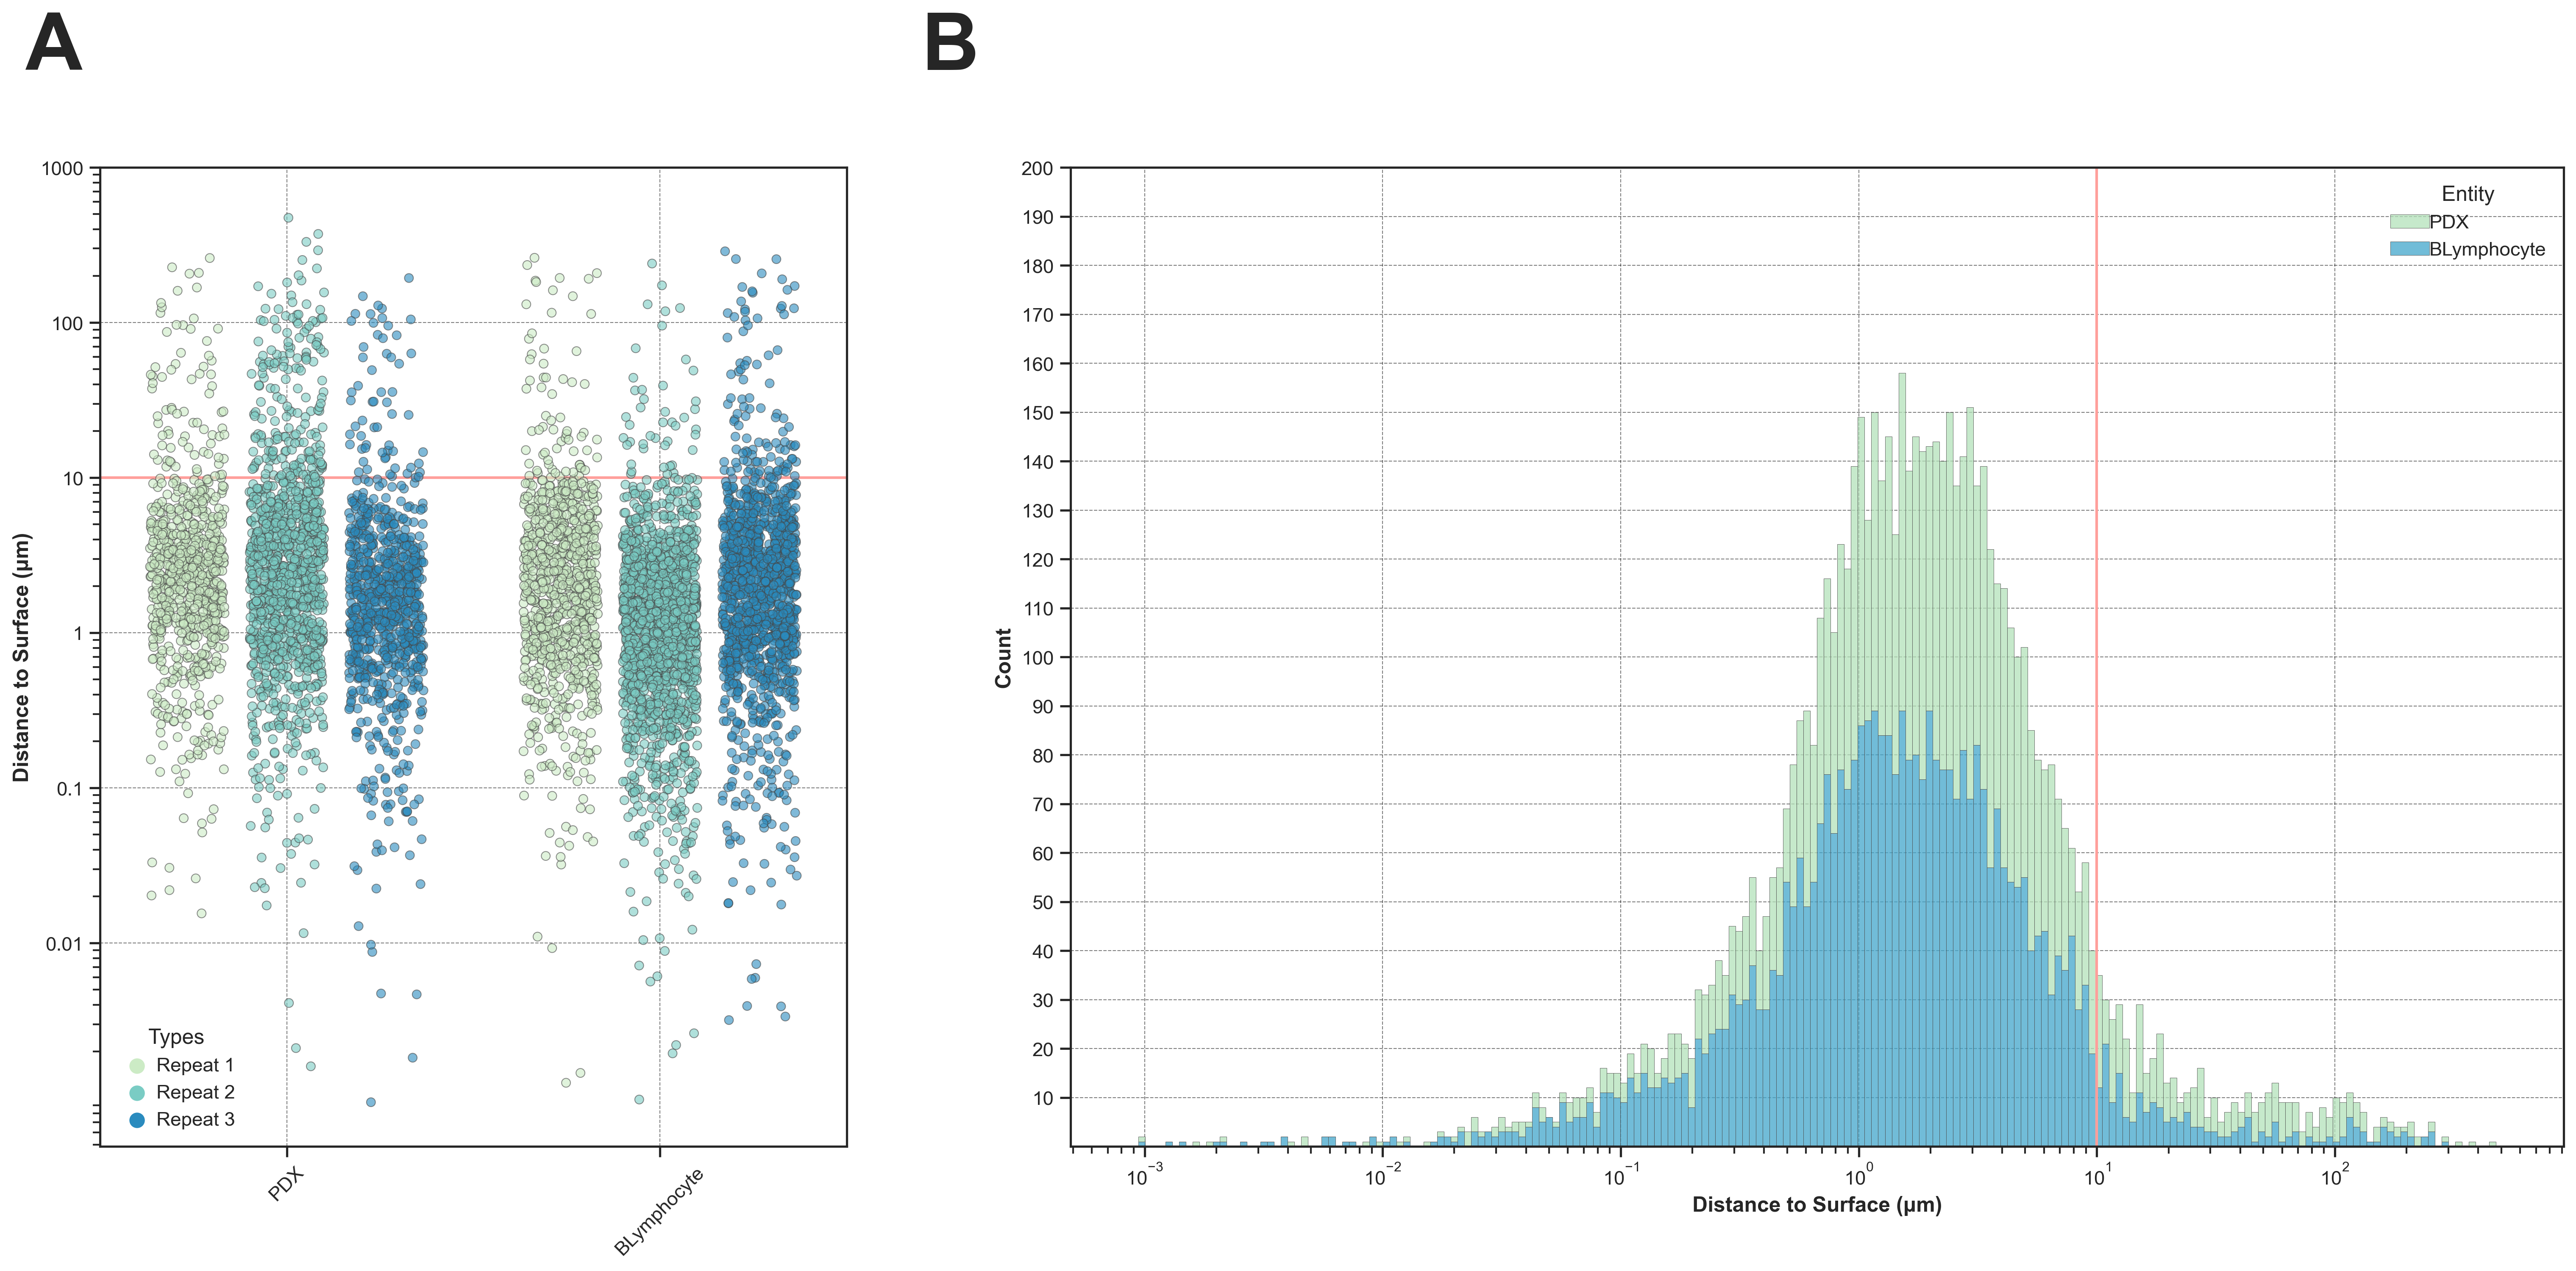

In [17]:
sns.set_theme(style="ticks", palette="pastel")
fig, axes = plt.subplots(1, 2, figsize=(25, 10), gridspec_kw={'width_ratios': [1, 2]})
g = sns.stripplot(ax=axes[0], data=df_final,
              x="Entity", y="Distance to Surface (\u03BCm)",
              hue="Types", palette="GnBu", linewidth=0.5,
              size=5, alpha=0.6, jitter=.30, dodge=True,
                 )
    
g.set_yscale("log")
# the non-logarithmic labels
ticks = [0.01, 0.1, 1, 10, 100, 1000]
g.set_yticks(ticks)
g.set_yticklabels(ticks)

g.tick_params(axis='x', rotation=45)
g.xaxis.label.set_visible(False)

sns.move_legend(
    g, loc="best", ncol=1, frameon=False, columnspacing=5, handletextpad=0
)

g.axhline(10, color='r')

g = sns.histplot(
    df_final,
    x="Distance to Surface (\u03BCm)", hue="Entity",
    bins=200,
    multiple="stack",
    palette="GnBu",
    element="bars",
    edgecolor=".3",
    common_norm=False,
    kde=False,
    pmax=1000,
    linewidth=.2,
    stat="count",
    log_scale=True,
)

sns.move_legend(
    g, loc="best", ncol=1, frameon=False, columnspacing=5, handletextpad=0)

axes[0].grid(color='black', alpha=0.5, linestyle='dashed', linewidth=0.5)
axes[0].set_xlabel('Entity', fontweight ='bold')
axes[0].set_ylabel('Distance to Surface (\u03BCm)', fontweight ='bold')
ticks = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
g.set_yticks(ticks)
g.set_yticklabels(ticks)

axes[1].grid(color='black', alpha=0.5, linestyle='dashed', linewidth=0.5)
axes[1].set_xlabel('Distance to Surface (\u03BCm)', fontweight ='bold')
axes[1].set_ylabel('Count', fontweight ='bold')
ticks = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]
g.set_yticks(ticks)
g.set_yticklabels(ticks)

g.axvline(x=10, color='r')


texts = ['A', 'B']
ax = fig.get_axes()
for a,l in zip(ax, texts):
    a.annotate(l, xy=(-0.1, 1.1), xycoords="axes fraction", fontsize=45, weight = 'bold')

plt.savefig(plot_savepath('Seaborn_697_v BCell.pdf'), bbox_inches='tight')
plt.savefig(plot_savepath('Seaborn_697_v BCell.png'), dpi=300, bbox_inches='tight')

plt.show()

In [10]:
#vis = o3d.visualization.Visualizer()
#vis.create_window(visible=False) #works for me with False, on some systems needs to be true
#vis.add_geometry(final_mesh_org)
#vis.update_geometry(final_mesh_org)
#vis.poll_events()
#vis.update_renderer()
#vis.capture_screen_image(plot_savepath('1857.png'), do_render=True)
#vis.destroy_window()